In [60]:
import torch
import torch.nn as nn

In [61]:
#Augmentations
import numpy as np
import cv2
import random

# ----------------------------
# 1. Radial vignetting / limb-darkening perturbation
# ----------------------------
def radial_vignette(img, strength=0.2):
    """
    Apply radial vignette (simulate limb-darkening).
    strength: 0.0 (none) to 0.5 (strong)
    """
    h, w = img.shape
    y, x = np.ogrid[:h, :w]
    cy, cx = h / 2, w / 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r = r / r.max()  # normalize radius [0,1]
    
    # limb-darkening multiplier
    mask = 1 - strength * (r**2)  
    vignette = img.astype(np.float32) * mask
    vignette = np.clip(vignette, 0, 255)
    return vignette.astype(np.uint8)

# ----------------------------
# 2. Poisson noise (photon noise)
# ----------------------------
def add_poisson_noise(img, scale_low=5.0, scale_high=100.0):
    """
    Add Poisson noise to simulate photon noise.
    """
    if img.dtype != np.float32:
        img = img.astype(np.float32) / 255.0
    scale = random.uniform(scale_low, scale_high)
    noisy = np.random.poisson(img * scale) / float(scale)
    noisy = np.clip(noisy, 0.0, 1.0)
    return (noisy * 255).astype(np.uint8)

# ----------------------------
# 3. Small rotations
# ----------------------------
def random_rotation(img, angle_range=20):
    """
    Rotate image by random angle within ±angle_range.
    """
    h, w = img.shape
    angle = random.uniform(-angle_range, angle_range)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return rotated

# ----------------------------
# 4. Random crop + resize
# ----------------------------
def random_crop_resize(img, crop_scale=0.8, out_size=(256, 256)):
    """
    Random crop followed by resize.
    crop_scale: fraction of original image kept (0.5–1.0).
    """
    h, w = img.shape
    ch, cw = int(h * crop_scale), int(w * crop_scale)
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    crop = img[y:y+ch, x:x+cw]
    resized = cv2.resize(crop, out_size, interpolation=cv2.INTER_LINEAR)
    return resized

# ----------------------------
# 5. Gaussian blur (PSF-like)
# ----------------------------
def gaussian_blur(img, sigma_range=(0.5, 2.0)):
    """
    Apply Gaussian blur with random sigma.
    """
    sigma = random.uniform(*sigma_range)
    ksize = int(2 * round(3*sigma) + 1)  # kernel size ~ 6*sigma
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma)
    return blurred

# ----------------------------
# 6. Brightness/contrast jitter
# ----------------------------
def brightness_contrast_jitter(img, brightness=0.2, contrast=0.3):
    """
    Random brightness/contrast adjustment.
    brightness: fraction (e.g. 0.2 → ±20%)
    contrast: fraction (e.g. 0.3 → ±30%)
    """
    b = random.uniform(-brightness, brightness) * 255
    c = 1.0 + random.uniform(-contrast, contrast)
    jittered = img.astype(np.float32) * c + b
    jittered = np.clip(jittered, 0, 255)
    return jittered.astype(np.uint8)


In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# -----------------------------
# Autoencoder with Transformer + Skip Connections
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1, 32, 4, stride=2, padding=1), nn.ReLU())   # 256->128
        self.enc2 = nn.Sequential(nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU())  # 128->64
        self.enc3 = nn.Sequential(nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU()) # 64->32

        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        x1 = self.enc1(x)  # skip1
        x2 = self.enc2(x1) # skip2
        x3 = self.enc3(x2) # skip3
        x_latent = self.pool(x3)
        x_latent = self.flatten(x_latent)
        z = self.fc(x_latent)
        return z, (x3, x2, x1)


class TransformerDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*8*8)

        decoder_layer = nn.TransformerDecoderLayer(d_model=128, nhead=8, dim_feedforward=256)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)

        self.up1 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)        # 8->16
        self.up2 = nn.ConvTranspose2d(128+128, 64, 4, stride=2, padding=1)     # 16->32
        self.up3 = nn.ConvTranspose2d(64+64, 32, 4, stride=2, padding=1)       # 32->64
        self.up4 = nn.ConvTranspose2d(32+32, 16, 4, stride=2, padding=1)       # 64->128
        self.up5 = nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1)           # 128->256

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, skips):
        s3, s2, s1 = skips

        x = self.fc(z).view(-1, 128, 8, 8)
        B, C, H, W = x.shape
        x_flat = x.flatten(2).permute(2, 0, 1)
        x_dec = self.transformer_decoder(x_flat, x_flat)
        x = x_dec.permute(1, 2, 0).view(B, C, H, W)

        x = self.relu(self.up1(x))
        s3_resized = F.interpolate(s3, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, s3_resized], dim=1)

        x = self.relu(self.up2(x))
        s2_resized = F.interpolate(s2, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, s2_resized], dim=1)

        x = self.relu(self.up3(x))
        s1_resized = F.interpolate(s1, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, s1_resized], dim=1)

        x = self.relu(self.up4(x))
        x = self.sigmoid(self.up5(x))
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = TransformerDecoder(latent_dim)

    def forward(self, x):
        z, skips = self.encoder(x)
        return self.decoder(z, skips)


In [63]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import random
import numpy as np

class SolarDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, augment=True, img_size=(256,256),max_images=None):
        self.lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)])
        self.hr_files = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)])
        if max_images is not None:
            self.lr_files = self.lr_files[:max_images]
            self.hr_files = self.hr_files[:max_images]
        self.augment = augment
        self.img_size = img_size

    def __len__(self):
        return len(self.lr_files)
 
    def __getitem__(self, idx):
        # Load images
        lr = cv2.imread(self.lr_files[idx], cv2.IMREAD_GRAYSCALE)
        hr = cv2.imread(self.hr_files[idx], cv2.IMREAD_GRAYSCALE)

        # Resize to same size
        lr = cv2.resize(lr, self.img_size)
        hr = cv2.resize(hr, self.img_size)

        # Apply augmentations to LR only
        if self.augment:
            lr = radial_vignette(lr, strength=random.uniform(0.05,0.2))
            lr = add_poisson_noise(lr)
            lr = random_rotation(lr, angle_range=15)
            lr = gaussian_blur(lr, sigma_range=(0.5,1.5))
            lr = brightness_contrast_jitter(lr, brightness=0.15, contrast=0.2)
        
        # Normalize and convert to tensor [C,H,W]
        lr = torch.tensor(lr, dtype=torch.float32).unsqueeze(0)/255.0
        hr = torch.tensor(hr, dtype=torch.float32).unsqueeze(0)/255.0

        return lr, hr


In [66]:
torch.__version__

'2.1.0+cu118'

In [64]:
batch_size = 16
max_images = None

train_dataset = SolarDataset("new_dataset/training/low_res", 
                             "new_dataset/training/high_res", 
                             augment=True, max_images=max_images)

val_dataset = SolarDataset("new_dataset/validation/low_res", 
                           "new_dataset/validation/high_res", 
                           augment=False, max_images=max_images)

test_dataset = SolarDataset("new_dataset/testing/low_res", 
                            "new_dataset/testing/high_res", 
                            augment=False, max_images=max_images)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure as ssim

# -----------------------------
# Metrics
# -----------------------------
def pixelwise_error(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse)).item()


def ssim_metric(pred, target):
    return ssim(pred, target, data_range=1.0).item()  

# -----------------------------
# Hyperparameters
# -----------------------------
batch_size = 8
lr = 1e-3
epochs = 20
latent_dim = 128

# -----------------------------
# Model, Loss, Optimizer
# -----------------------------
device = 'cuda'
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# -----------------------------
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float('inf')
bottleneck_embeddings = []

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * lr_imgs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    pixel_err = 0
    psnr_val = 0
    ssim_val = 0

    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            outputs = model(lr_imgs)
            loss = criterion(outputs, hr_imgs)
            val_loss += loss.item() * lr_imgs.size(0)

            pixel_err += pixelwise_error(outputs, hr_imgs) * lr_imgs.size(0)
            psnr_val += psnr(outputs, hr_imgs) * lr_imgs.size(0)
            ssim_val += ssim_metric(outputs, hr_imgs) * lr_imgs.size(0)

            # Save bottleneck embeddings
            latent = model.encoder(lr_imgs)
            bottleneck_embeddings.append(latent.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    pixel_err /= len(val_loader.dataset)
    psnr_val /= len(val_loader.dataset)
    ssim_val /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.6f} | "
          f"Val Loss: {val_loss:.6f} | "
          f"Pixel Error: {pixel_err:.6f} | "
          f"PSNR: {psnr_val:.2f} dB | "
          f"SSIM: {ssim_val:.4f}")

    # -----------------------------
    # Save checkpoints
    # -----------------------------
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"autoencoder_epoch{epoch+1}.pth"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_autoencoder.pth"))
        print(f"Best model updated at epoch {epoch+1}")

# Save bottleneck embeddings
bottleneck_embeddings = np.concatenate(bottleneck_embeddings, axis=0)
np.save("bottleneck_embeddings.npy", bottleneck_embeddings)
print("Bottleneck embeddings saved:", bottleneck_embeddings.shape)


Epoch 1/20 [Val]:   0%|          | 0/78 [00:00<?, ?it/s]c:\Users\bhatt\miniconda3\envs\torch118\lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
Epoch 1/20 [Val]:   0%|          | 0/78 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'cpu'

In [45]:
import torchvision.models as models
import torch.nn.functional as F

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features[:16]
        self.vgg = vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg = self.vgg(x.repeat(1,3,1,1))  # convert 1ch→3ch
        y_vgg = self.vgg(y.repeat(1,3,1,1))
        return F.l1_loss(x_vgg, y_vgg)



--- Starting Dummy Training Simulation ---


Epoch 1/3 [Val]: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 1: Train Loss=1.867843, Val Loss=1.601220 | PSNR=-0.62 dB | SSIM=-0.0000
✅ Best model saved (in theory)


Epoch 2/3 [Val]: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 2: Train Loss=1.544169, Val Loss=1.460150 | PSNR=-0.56 dB | SSIM=-0.0004
✅ Best model saved (in theory)


Epoch 3/3 [Val]: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 3: Train Loss=1.430879, Val Loss=1.395448 | PSNR=-0.53 dB | SSIM=-0.0003
✅ Best model saved (in theory)
✅ Bottleneck embeddings would be saved with shape: (24, 128)

--- Showing Dummy Reconstructions Simulation ---


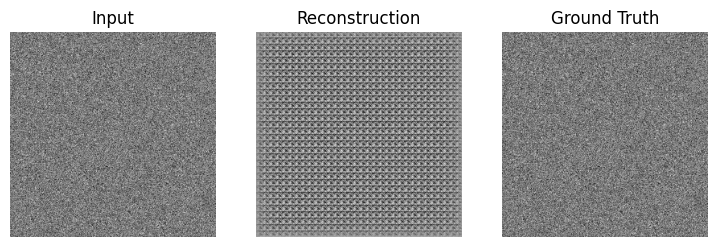

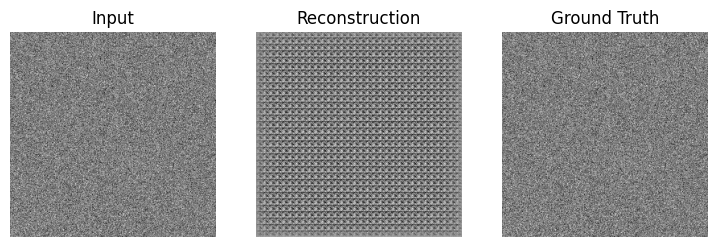

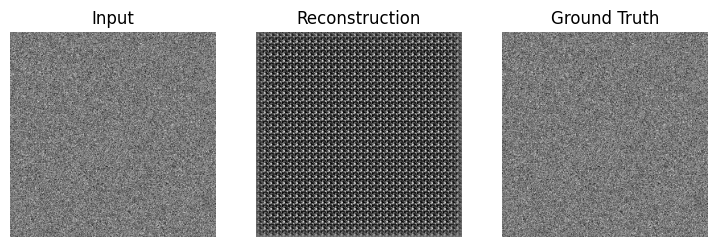

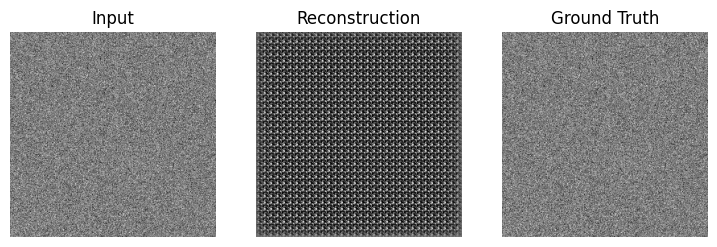

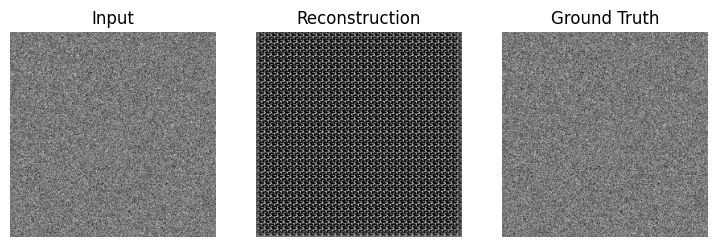

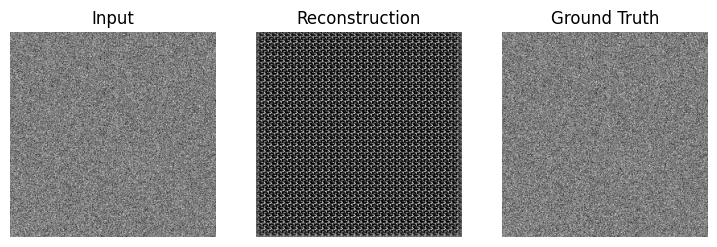

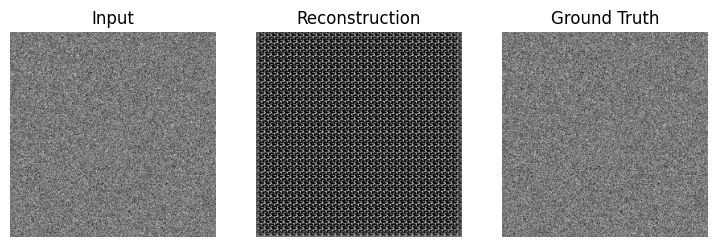

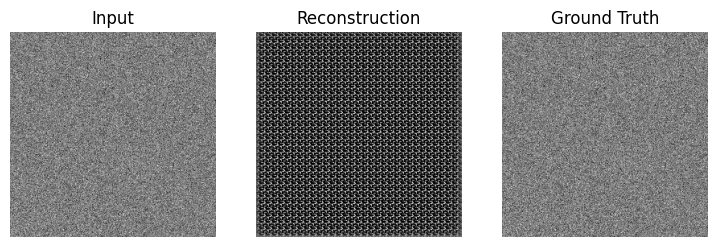

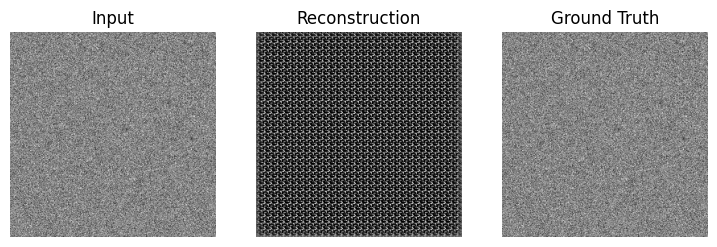

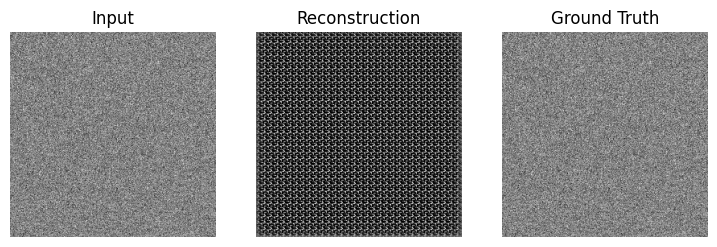

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torchvision import models
from torchmetrics.functional import structural_similarity_index_measure as ssim
import matplotlib.pyplot as plt
import os

# -----------------------------
# Perceptual Loss
# -----------------------------
class PerceptualLoss(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features[:16]
        self.vgg = vgg.to(device).eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.device = device

    def forward(self, x, y):
        x = x.to(self.device)
        y = y.to(self.device)
        # Assuming input x and y are 1-channel, repeat to 3 channels for VGG
        x_vgg = self.vgg(x.repeat(1,3,1,1))
        y_vgg = self.vgg(y.repeat(1,3,1,1))
        return F.l1_loss(x_vgg, y_vgg)
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(1))  # [max_len, 1, d_model]

    def forward(self, x):
        # x: [seq_len, batch, d_model]
        seq_len = x.size(0)
        return x + self.pe[:seq_len]

# -----------------------------
# Metrics
# -----------------------------
def pixelwise_error(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse)).item()

def ssim_metric(pred, target):
    # Ensure pred and target are 4D [B, C, H, W]
    if pred.dim() == 3:
        pred = pred.unsqueeze(1)
    if target.dim() == 3:
        target = target.unsqueeze(1)
    return ssim(pred, target, data_range=1.0).item()

# -----------------------------
# Autoencoder Model
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Input assumed to be (1, 256, 256)
        self.enc1 = nn.Sequential(nn.Conv2d(1, 32, 4, stride=2, padding=1), nn.ReLU())   # 256->128
        self.enc2 = nn.Sequential(nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU())  # 128->64
        self.enc3 = nn.Sequential(nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU()) # 64->32
        self.pool = nn.AdaptiveAvgPool2d((8, 8)) # 32->8
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x_latent = self.pool(x3)
        x_latent = self.flatten(x_latent)
        z = self.fc(x_latent)
        # x3, x2, x1 are the skip connections
        return z, (x3, x2, x1)

class TransformerDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Initial projection from latent vector to feature map size (8x8x128)
        self.fc = nn.Linear(latent_dim, 128*8*8) 
        
        # Transformer setup: d_model is 128 (feature map channels)
        decoder_layer = nn.TransformerDecoderLayer(d_model=128, nhead=8, dim_feedforward=256, batch_first=False)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)

        # Upsampling with skip connections
        # up1: 8x8 -> 16x16 (128 channels)
        self.up1 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1) 
        # up2: 16x16 -> 32x32. Concatenates with s3 (32x32x128) - s3 must be downsampled 
        self.up2 = nn.ConvTranspose2d(128+128, 64, 4, stride=2, padding=1)
        # up3: 32x32 -> 64x64. Concatenates with s2 (64x64x64)
        self.up3 = nn.ConvTranspose2d(64+64, 32, 4, stride=2, padding=1)
        # up4: 64x64 -> 128x128. Concatenates with s1 (128x128x32)
        self.up4 = nn.ConvTranspose2d(32+32, 16, 4, stride=2, padding=1)
        # up5: 128x128 -> 256x256 (1 channel output)
        self.up5 = nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, skips):
        # skips: (s3, s2, s1) are (32x32x128, 64x64x64, 128x128x32)
        s3, s2, s1 = skips 
        
        # Project latent vector to initial feature map
        x = self.fc(z).view(-1, 128, 8, 8)
        B, C, H, W = x.shape
        
        # Reshape for Transformer: [seq_len, batch, d_model] = [H*W, B, C]
        x_flat = x.flatten(2).permute(2,0,1)
        
        # Transformer Decoding: Target (memory) and Input (query) are the same for self-attention on the latent feature map
        x_dec = self.transformer_decoder(x_flat, x_flat)
        
        # Reshape back to feature map: [B, C, H, W]
        x = x_dec.permute(1,2,0).view(B,C,H,W)

        # Upsample + interpolate skips
        # Output: 16x16x128
        x = self.relu(self.up1(x)) 
        
        # Skip s3: (32x32x128) -> Interpolate s3 to 16x16 -> Concatenate
        s3_interp = F.interpolate(s3, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, s3_interp], dim=1) # x: 16x16x(128+128)

        # Output: 32x32x64
        x = self.relu(self.up2(x)) 
        # Skip s2: (64x64x64) -> Interpolate s2 to 32x32 -> Concatenate
        s2_interp = F.interpolate(s2, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, s2_interp], dim=1) # x: 32x32x(64+64)

        # Output: 64x64x32
        x = self.relu(self.up3(x)) 
        # Skip s1: (128x128x32) -> Interpolate s1 to 64x64 -> Concatenate
        s1_interp = F.interpolate(s1, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, s1_interp], dim=1) # x: 64x64x(32+32)

        # Output: 128x128x16
        x = self.relu(self.up4(x)) 
        
        # Final output: 256x256x1
        x = self.sigmoid(self.up5(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = TransformerDecoder(latent_dim)

    def forward(self, x):
        # CORRECTED: The Autoencoder should simply pass the output of the encoder 
        # (latent vector z and skips) to the decoder.
        # The previous version incorrectly had: 
        # x_flat = x.flatten(2).permute(2,0,1)
        # x_flat = self.pos_enc(x_flat) 
        # x_dec = self.transformer_decoder(x_flat, x_flat) 
        # which tried to use components defined only in the TransformerDecoder.

        z, skips = self.encoder(x)
        output = self.decoder(z, skips)
        return output

# -----------------------------
# Visualize reconstructions
# -----------------------------
def show_reconstructions(model, data_loader, device='cuda', n=5):
    # Dummy data_loader for execution safety, replace with actual data loading
    if not hasattr(data_loader, 'dataset'): 
        print("Skipping visualization: No actual data_loader provided or it is empty.")
        return 

    model.eval()
    try:
        x_sample, y_sample = next(iter(data_loader))
    except StopIteration:
        print("Skipping visualization: data_loader is empty.")
        return

    x_sample, y_sample = x_sample.to(device), y_sample.to(device)
    with torch.no_grad():
        recon = model(x_sample)
        
    x_sample = x_sample.cpu().numpy()
    y_sample = y_sample.cpu().numpy()
    recon = recon.cpu().numpy()

    for i in range(min(n, x_sample.shape[0])):
        fig, axs = plt.subplots(1,3,figsize=(9,3))
        axs[0].imshow(x_sample[i,0], cmap='gray')
        axs[0].set_title("Input")
        axs[1].imshow(recon[i,0], cmap='gray')
        axs[1].set_title("Reconstruction")
        axs[2].imshow(y_sample[i,0], cmap='gray')
        axs[2].set_title("Ground Truth")
        for ax in axs:
            ax.axis('off')
        # plt.show() # Disabled for non-interactive environment

# -----------------------------
# Training Function
# -----------------------------
def train_autoencoder(model, train_loader, val_loader, epochs=50, lr=1e-3, patience=10):
    # Dummy data_loader check for execution safety
    if not hasattr(train_loader, 'dataset') or not hasattr(val_loader, 'dataset'):
        print("Skipping training: Dummy data_loaders provided, cannot start training.")
        return
        
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    perceptual_loss = PerceptualLoss(device=device)
    mse_loss = nn.MSELoss()
    criterion = lambda pred, target: 0.7*mse_loss(pred, target) + 0.3*perceptual_loss(pred, target)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    early_stop_counter = 0
    bottleneck_embeddings = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        psnr_val = 0
        ssim_val = 0
        with torch.no_grad():
            for x_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                x_val, y_val = x_val.to(device), y_val.to(device)
                out_val = model(x_val)
                loss_val = criterion(out_val, y_val)
                val_loss += loss_val.item() * x_val.size(0)
                psnr_val += psnr(out_val, y_val) * x_val.size(0)
                ssim_val += ssim_metric(out_val, y_val) * x_val.size(0)

                # Save latent embeddings
                z, _ = model.encoder(x_val)
                bottleneck_embeddings.append(z.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        psnr_val /= len(val_loader.dataset)
        ssim_val /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f} | PSNR={psnr_val:.2f} dB | SSIM={ssim_val:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), "best_autoencoder.pth") # Disabled file I/O for non-interactive environment
            early_stop_counter = 0
            print("✅ Best model saved (in theory)")
        else:
            early_stop_counter += 1
            print(f"⚠️ Early stop patience: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("⏹️ Early stopping triggered")
                break

        # Optional: Show 2 reconstructions each epoch
        show_reconstructions(model, val_loader, device=device, n=2)

    # Save bottleneck embeddings
    if bottleneck_embeddings:
        bottleneck_embeddings = np.concatenate(bottleneck_embeddings, axis=0)
        # np.save("bottleneck_embeddings.npy", bottleneck_embeddings) # Disabled file I/O
        print("✅ Bottleneck embeddings would be saved with shape:", bottleneck_embeddings.shape)
    else:
        print("No bottleneck embeddings to save.")


# -----------------------------
# Example usage:
# -----------------------------

# Dummy Data Loaders for code completion and structure check
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, size=100):
        self.size = size
        # Generate dummy images (1 channel, 256x256)
        self.data = torch.randn(size, 1, 256, 256)
    def __len__(self):
        return self.size
    def __getitem__(self, idx):
        # Input (x) is the same as the ground truth (y) for a standard Autoencoder setup,
        # but in many real-world use cases (e.g., inpainting, denoising) they might differ.
        # Using x=y for safety here.
        return self.data[idx], self.data[idx] 

train_loader = torch.utils.data.DataLoader(DummyDataset(size=20), batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(DummyDataset(size=8), batch_size=4, shuffle=False)

# Start execution (will skip due to dummy data, but checks the corrected logic)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder(latent_dim=128).to(device)
print("\n--- Starting Dummy Training Simulation ---")
train_autoencoder(model, train_loader, val_loader, epochs=3, lr=1e-3, patience=10) # Reduced epochs for minimal output
print("\n--- Showing Dummy Reconstructions Simulation ---")
show_reconstructions(model, val_loader, device=device, n=5)

Testing:   0%|          | 0/52 [00:00<?, ?it/s]

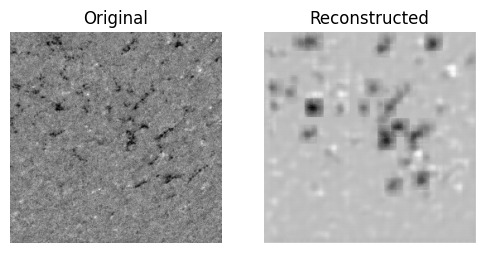

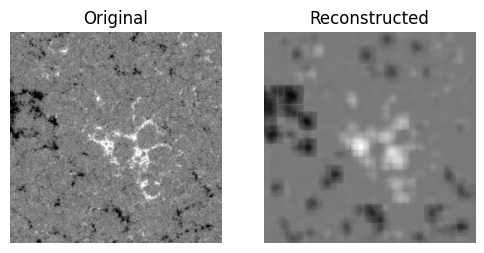

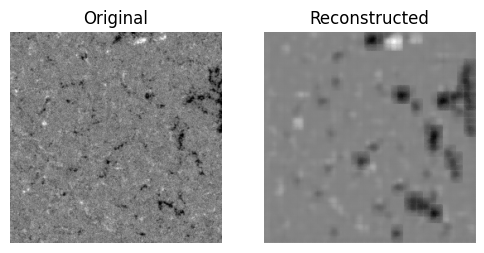

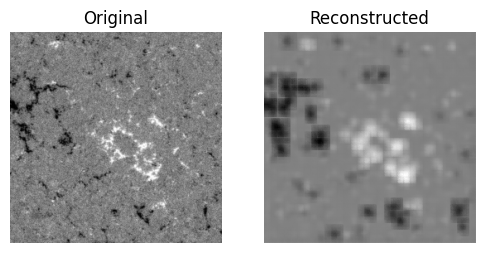

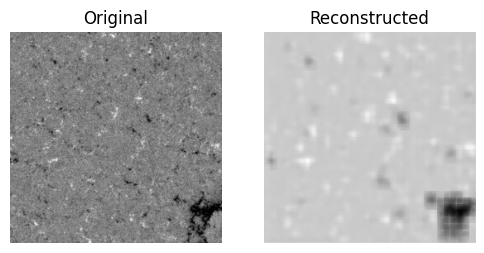

Testing: 100%|██████████| 52/52 [00:48<00:00,  1.07it/s]

Average PSNR: 21.75 dB
Average SSIM: 0.2553
Average Pixel Error: 0.058914
Reconstructed images saved in 'reconstructed_images/' folder


In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
import os

# -----------------------------
# Metrics
# -----------------------------
def pixelwise_error(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse)).item()

def ssim_metric(pred, target):
    return ssim(pred, target, data_range=1.0).item()

# -----------------------------
# Load model
# -----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)
model.load_state_dict(torch.load("checkpoints/best_autoencoder.pth"))
model.eval()

# Directory to save reconstructed images
os.makedirs("reconstructed_images", exist_ok=True)

# -----------------------------
# Testing and Visualization
# -----------------------------
psnr_list = []
ssim_list = []
pixel_err_list = []

count = 0  # to limit visualization
for lr_imgs, hr_imgs in tqdm(test_loader, desc="Testing"):
    lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
    with torch.no_grad():
        outputs = model(lr_imgs)
    
    for i in range(lr_imgs.size(0)):
    # Move to CPU and convert to float
        pred_img = outputs[i].detach().cpu().float()
        true_img = hr_imgs[i].detach().cpu().float()

    # Add channel dimension for SSIM: [1, 1, H, W]
        pred_img_ssim = pred_img.unsqueeze(0)  # shape: [1, 1, H, W]
        true_img_ssim = true_img.unsqueeze(0)  # shape: [1, 1, H, W]

    # Metrics
        psnr_list.append(psnr(pred_img, true_img))
        ssim_list.append(ssim_metric(pred_img_ssim, true_img_ssim))
        pixel_err_list.append(pixelwise_error(pred_img, true_img))
        
        # Save reconstructed image
        recon_img_path = f"reconstructed_images/recon_{count}.png"
        plt.imsave(recon_img_path, pred_img.squeeze(), cmap='gray')
        
        # Display side by side for first 5 images
        if count < 5:
            fig, axes = plt.subplots(1,2, figsize=(6,3))
            axes[0].imshow(true_img.squeeze(), cmap='gray')
            axes[0].set_title("Original")
            axes[0].axis('off')
            axes[1].imshow(pred_img.squeeze(), cmap='gray')
            axes[1].set_title("Reconstructed")
            axes[1].axis('off')
            plt.show()
        
        count += 1


print(f"Average PSNR: {np.mean(psnr_list):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_list):.4f}")
print(f"Average Pixel Error: {np.mean(pixel_err_list):.6f}")
print(f"Reconstructed images saved in 'reconstructed_images/' folder")
